In [1]:
#Importation des librairies
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
from sklearn import preprocessing
from sklearn import utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot, prediction_error

from time import time

pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rmpse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    return loss

def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE, MAPE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmpse_cal = rmpse(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("RMPSE: ", rmpse_cal.round(3))
    print("MAPE: ", mape.round(5))
    print("R²: ", r_score.round(5))

In [3]:
df = pd.read_csv("projet3.csv", sep=',')

In [4]:
df.shape

(1050, 21)

In [5]:
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 4 categorical variables

The categorical variables are :

 ['PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']


In [6]:
df[categorical].head()

,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,Hotel,Hotel,NaN,NaN
1,Hotel,Hotel,Parking,Restaurant
2,Hotel,Hotel,NaN,NaN
3,Hotel,Hotel,NaN,NaN
4,Hotel,Hotel,Parking,Swimming Pool


In [7]:
for var in categorical: 
    
    print(df[var].value_counts())

Small- and Mid-Sized Office    235
Large Office                   156
Warehouse                      143
K-12 School                    124
Retail Store                    78
Hotel                           72
Worship Facility                63
Distribution Center             40
Supermarket / Grocery Store     38
Medical Office                  37
Mixed Use Property              18
Senior Care Community           18
Other                           11
Hospital                         9
Refrigerated Warehouse           5
Office                           3
Name: PrimaryPropertyType, dtype: int64
Office                                   401
Non-Refrigerated Warehouse               145
K-12 School                              124
Retail Store                              78
Hotel                                     72
Worship Facility                          63
Distribution Center                       41
Medical Office                            37
Supermarket/Grocery Store               

In [8]:
for var in categorical:
    
     print(df[var].value_counts()/np.float(len(df)))

Small- and Mid-Sized Office   0.22
Large Office                  0.15
Warehouse                     0.14
K-12 School                   0.12
Retail Store                  0.07
Hotel                         0.07
Worship Facility              0.06
Distribution Center           0.04
Supermarket / Grocery Store   0.04
Medical Office                0.04
Mixed Use Property            0.02
Senior Care Community         0.02
Other                         0.01
Hospital                      0.01
Refrigerated Warehouse        0.00
Office                        0.00
Name: PrimaryPropertyType, dtype: float64
Office                                  0.38
Non-Refrigerated Warehouse              0.14
K-12 School                             0.12
Retail Store                            0.07
Hotel                                   0.07
Worship Facility                        0.06
Distribution Center                     0.04
Medical Office                          0.04
Supermarket/Grocery Store             

In [9]:
df['TotalGHGEmissions_log'].isnull().sum()

0

In [10]:
df['TotalGHGEmissions_log'].nunique()

1018

In [11]:
df.shape

(1050, 21)

In [12]:
numerical = [var for var in df.columns if df[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :\n\n', numerical)

There are 17 numerical variables

The numerical variables are :

 ['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log', 'SourceEUI(kBtu/sf)_binary', 'SiteEnergyUse(kBtu)_binary', 'SteamUse(kBtu)_binary', 'Electricity(kBtu)_binary', 'NaturalGas(kBtu)_binary']


In [13]:
df[numerical].head()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,SourceEUI(kBtu/sf)_binary,SiteEnergyUse(kBtu)_binary,SteamUse(kBtu)_binary,Electricity(kBtu)_binary,NaturalGas(kBtu)_binary
0,1.00,12,0,88434,"88,434.00",0.00,0.00,60.00,"7,226,362.50",249.98,15.79,5.52,1,1,1,1,1
1,1.00,11,15064,88502,"83,880.00","15,064.00","4,622.00",61.00,"8,387,933.00",295.86,15.94,5.69,1,1,0,1,1
2,1.00,41,196718,759392,"756,493.00",0.00,0.00,43.00,"72,587,024.00","2,089.28",18.10,7.64,1,1,1,1,1
3,1.00,10,0,61320,"61,320.00",0.00,0.00,56.00,"6,794,584.00",286.43,15.73,5.66,1,1,1,1,1
4,1.00,18,62000,113580,"123,445.00","68,009.00",0.00,75.00,"14,172,606.00",505.01,16.47,6.22,1,1,0,1,1


In [14]:
df[numerical].isnull().sum()

NumberofBuildings                  0
NumberofFloors                     0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEnergyUse(kBtu)                0
TotalGHGEmissions                  0
SiteEnergyUse(kBtu)_log            0
TotalGHGEmissions_log              0
SourceEUI(kBtu/sf)_binary          0
SiteEnergyUse(kBtu)_binary         0
SteamUse(kBtu)_binary              0
Electricity(kBtu)_binary           0
NaturalGas(kBtu)_binary            0
dtype: int64

In [15]:
X = df.drop(['TotalGHGEmissions_log','TotalGHGEmissions','SiteEnergyUse(kBtu)_log','SiteEnergyUse(kBtu)'], axis=1)

y = df['TotalGHGEmissions_log']

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [17]:
X_train.shape, X_test.shape

((735, 17), (315, 17))

In [18]:
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

categorical

['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']

In [19]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)_binary',
 'SiteEnergyUse(kBtu)_binary',
 'SteamUse(kBtu)_binary',
 'Electricity(kBtu)_binary',
 'NaturalGas(kBtu)_binary']

In [20]:
X_train[categorical].isnull().mean()

PrimaryPropertyType            0.00
LargestPropertyUseType         0.00
SecondLargestPropertyUseType   0.52
ThirdLargestPropertyUseType    0.86
dtype: float64

In [21]:
X_train.isnull().sum()

PrimaryPropertyType                  0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType       383
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseType        631
ThirdLargestPropertyUseTypeGFA       0
ENERGYSTARScore                      0
SourceEUI(kBtu/sf)_binary            0
SiteEnergyUse(kBtu)_binary           0
SteamUse(kBtu)_binary                0
Electricity(kBtu)_binary             0
NaturalGas(kBtu)_binary              0
dtype: int64

In [22]:
X_test.isnull().sum()

PrimaryPropertyType                  0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType       188
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseType        274
ThirdLargestPropertyUseTypeGFA       0
ENERGYSTARScore                      0
SourceEUI(kBtu/sf)_binary            0
SiteEnergyUse(kBtu)_binary           0
SteamUse(kBtu)_binary                0
Electricity(kBtu)_binary             0
NaturalGas(kBtu)_binary              0
dtype: int64

In [23]:
import category_encoders as ce

In [24]:
encoder = ce.OneHotEncoder(cols=['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [25]:
X_test.head()

,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,PrimaryPropertyType_5,PrimaryPropertyType_6,PrimaryPropertyType_7,PrimaryPropertyType_8,PrimaryPropertyType_9,PrimaryPropertyType_10,PrimaryPropertyType_11,PrimaryPropertyType_12,PrimaryPropertyType_13,PrimaryPropertyType_14,PrimaryPropertyType_15,PrimaryPropertyType_16,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType_1,LargestPropertyUseType_2,LargestPropertyUseType_3,LargestPropertyUseType_4,LargestPropertyUseType_5,LargestPropertyUseType_6,LargestPropertyUseType_7,LargestPropertyUseType_8,LargestPropertyUseType_9,LargestPropertyUseType_10,LargestPropertyUseType_11,LargestPropertyUseType_12,LargestPropertyUseType_13,LargestPropertyUseType_14,LargestPropertyUseType_15,LargestPropertyUseType_16,LargestPropertyUseType_17,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType_1,SecondLargestPropertyUseType_2,SecondLargestPropertyUseType_3,SecondLargestPropertyUseType_4,SecondLargestPropertyUseType_5,SecondLargestPropertyUseType_6,SecondLargestPropertyUseType_7,SecondLargestPropertyUseType_8,SecondLargestPropertyUseType_9,SecondLargestPropertyUseType_10,SecondLargestPropertyUseType_11,SecondLargestPropertyUseType_12,SecondLargestPropertyUseType_13,SecondLargestPropertyUseType_14,SecondLargestPropertyUseType_15,SecondLargestPropertyUseType_16,SecondLargestPropertyUseType_17,SecondLargestPropertyUseType_18,SecondLargestPropertyUseType_19,SecondLargestPropertyUseType_20,SecondLargestPropertyUseType_21,SecondLargestPropertyUseType_22,SecondLargestPropertyUseType_23,SecondLargestPropertyUseType_24,SecondLargestPropertyUseType_25,SecondLargestPropertyUseType_26,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType_1,ThirdLargestPropertyUseType_2,ThirdLargestPropertyUseType_3,ThirdLargestPropertyUseType_4,ThirdLargestPropertyUseType_5,ThirdLargestPropertyUseType_6,ThirdLargestPropertyUseType_7,ThirdLargestPropertyUseType_8,ThirdLargestPropertyUseType_9,ThirdLargestPropertyUseType_10,ThirdLargestPropertyUseType_11,ThirdLargestPropertyUseType_12,ThirdLargestPropertyUseType_13,ThirdLargestPropertyUseType_14,ThirdLargestPropertyUseType_15,ThirdLargestPropertyUseType_16,ThirdLargestPropertyUseType_17,ThirdLargestPropertyUseType_18,ThirdLargestPropertyUseType_19,ThirdLargestPropertyUseType_20,ThirdLargestPropertyUseType_21,ThirdLargestPropertyUseType_22,ThirdLargestPropertyUseType_23,ThirdLargestPropertyUseType_24,ThirdLargestPropertyUseType_25,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SourceEUI(kBtu/sf)_binary,SiteEnergyUse(kBtu)_binary,SteamUse(kBtu)_binary,Electricity(kBtu)_binary,NaturalGas(kBtu)_binary
743,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,2,0,20671,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"20,671.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,98.00,1,1,0,1,1
656,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,1,0,35289,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"35,289.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,63.00,1,1,0,1,1
704,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,2,0,27574,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"27,574.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,73.00,1,1,0,1,0
738,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,3,21908,35224,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"33,705.00",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"21,908.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,73.00,1,1,0,1,0
496,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,1,0,23409,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"21,909.00",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,500.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,67.00,1,1,0,1,1


In [26]:
X_test.shape

(315, 97)

In [27]:
cols = X_train.columns

In [28]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [29]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [30]:
X_test = pd.DataFrame(X_test, columns=[cols])

### Dummy Regressor


In [31]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [32]:
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  1.15715
MSE:  2.22531
RMSE:  1.4917473898947993
RMPSE:  3.972
MAPE:  0.692
R²:  -0.00045


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
gdboost = GradientBoostingRegressor(random_state=10)
rdmforest = RandomForestRegressor(random_state=10)

In [34]:
model = [dummy_reg, lin_reg, gdboost, rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "GradientBoosting", "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,GradientBoosting,Random Forest
MAE,1.16,0.68,0.53,0.56
MSE,2.23,0.81,0.47,0.56
RMSE,1.49,0.90,0.69,0.75
R²,-0.00,0.64,0.79,0.75


Nous allons maintenant chercher les hyperparamètres pour chaque modèle afin de déterminer lequel sera le plus adapté à notre problème


In [35]:
# instanciation du modèle avec paramètre de base 
linear_reg = LinearRegression(n_jobs=-1)

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {}

rnd_search = RandomizedSearchCV(linear_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=LinearRegression(n_jobs=-1),
                   param_distributions={}, random_state=10,
                   scoring='neg_mean_squared_error')

In [37]:
final_model_energy_linear = rnd_search.best_estimator_

In [38]:
final_predictions_energy = final_model_energy_linear.predict(X_test)

In [39]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.68098
MSE:  0.81192
RMSE:  0.901068181187127
RMPSE:  1.25
MAPE:  0.31041
R²:  0.63498


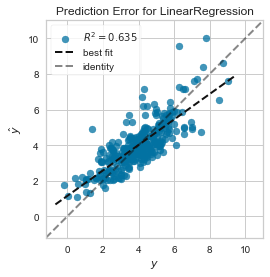

In [40]:
visualizer = prediction_error(final_model_energy_linear, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [41]:
# instanciation du modèle avec paramètre de base 
gdboost = GradientBoostingRegressor()

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10)
    }
rnd_search = RandomizedSearchCV(gdboost, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906C6220D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906C62AE80>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [43]:
rnd_search.best_params_

{'max_depth': 89,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 288}

In [44]:
final_model_energy_gdboost = rnd_search.best_estimator_

In [45]:
final_predictions_energy = final_model_energy_gdboost.predict(X_test)

In [46]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.5448
MSE:  0.51447
RMSE:  0.7172630483567157
RMPSE:  0.829
MAPE:  0.22356
R²:  0.76871


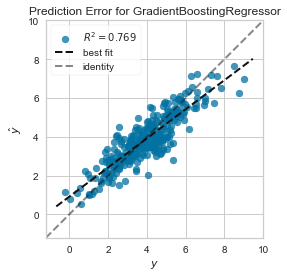

In [47]:
visualizer = prediction_error(final_model_energy_gdboost, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [48]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = regressor.predict(X_test)


In [49]:
# instanciation du modèle avec paramètre de base 
forest_reg = RandomForestRegressor(random_state=10, n_jobs=-1)

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10),
        "bootstrap" : [True, False]
    }

rnd_search = RandomizedSearchCV(regressor, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906D84C190>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906D86B640>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [51]:
rnd_search.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 555}

In [52]:
'''from sklearn.model_selection import GridSearchCV

params = [{"bootstrap":[True],
           "max_depth" : [79, 89, 99, 109, 119, 129],
           "max_features" : ["auto"],
           "min_samples_leaf" : [2, 3, 4],
           "min_samples_split" : [2,3,4],
           "n_estimators" : [900, 1000, 1100]
}]

grid_search = GridSearchCV(forest_reg, params, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)'''

'from sklearn.model_selection import GridSearchCV\n\nparams = [{"bootstrap":[True],\n           "max_depth" : [79, 89, 99, 109, 119, 129],\n           "max_features" : ["auto"],\n           "min_samples_leaf" : [2, 3, 4],\n           "min_samples_split" : [2,3,4],\n           "n_estimators" : [900, 1000, 1100]\n}]\n\ngrid_search = GridSearchCV(forest_reg, params, cv=5,\n                           scoring=\'neg_mean_squared_error\')\ngrid_search.fit(X_train, y_train)'

In [53]:
#grid_search.best_params_

In [54]:
final_model_energy_forest = rnd_search.best_estimator_

In [55]:
final_predictions_energy = final_model_energy_forest.predict(X_test)

In [56]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.56621
MSE:  0.56841
RMSE:  0.7539321888098851
RMPSE:  1.962
MAPE:  0.3079
R²:  0.74445


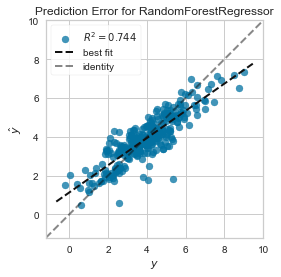

In [57]:
visualizer = prediction_error(final_model_energy_forest, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


Le random forest est donc le meilleur modèle pour notre problème

In [58]:
feature_importances_forest = pd.DataFrame(final_model_energy_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_gradient = pd.DataFrame(final_model_energy_gdboost.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [59]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_forest.head()

,importance
LargestPropertyUseTypeGFA,0.26
PropertyGFABuilding(s),0.25
NaturalGas(kBtu)_binary,0.19
ENERGYSTARScore,0.11
NumberofFloors,0.04


In [60]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_gradient.head()

,importance
LargestPropertyUseTypeGFA,0.31
NaturalGas(kBtu)_binary,0.15
PropertyGFABuilding(s),0.11
ENERGYSTARScore,0.10
SecondLargestPropertyUseTypeGFA,0.04


In [61]:
df = pd.read_csv("projet3.csv", sep=',')

X = df.drop(['TotalGHGEmissions_log','TotalGHGEmissions','SiteEnergyUse(kBtu)_log','SiteEnergyUse(kBtu)','ENERGYSTARScore'], axis=1)
y = df['TotalGHGEmissions_log']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

encoder = ce.OneHotEncoder(cols=['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

cols = X_train.columns

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [62]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [63]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [64]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  1.15715
MSE:  2.22531
RMSE:  1.4917473898947993
RMPSE:  3.972
MAPE:  0.692
R²:  -0.00045


In [65]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
gdboost = GradientBoostingRegressor(random_state=10)
rdmforest = RandomForestRegressor(random_state=10)

In [66]:
model = [dummy_reg, lin_reg, gdboost, rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "GradientBoosting", "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,GradientBoosting,Random Forest
MAE,1.16,0.73,0.58,0.62
MSE,2.23,0.93,0.61,0.69
RMSE,1.49,0.96,0.78,0.83
R²,-0.00,0.58,0.73,0.69


In [67]:
# instanciation du modèle avec paramètre de base 
linear_reg = LinearRegression(n_jobs=-1)

In [68]:
param_distribs = {}

rnd_search = RandomizedSearchCV(linear_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LinearRegression(n_jobs=-1),
                   param_distributions={}, random_state=10,
                   scoring='neg_mean_squared_error')

In [69]:
final_model_energy_linear = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_linear.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.73167
MSE:  0.92844
RMSE:  0.9635560905895019
RMPSE:  1.773
MAPE:  0.36449
R²:  0.58259


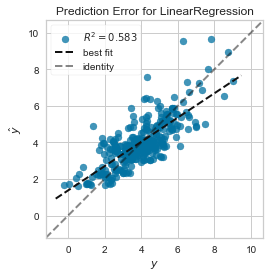

In [70]:
visualizer = prediction_error(final_model_energy_linear, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [71]:
gdboost = GradientBoostingRegressor()
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10)
    }
rnd_search = RandomizedSearchCV(gdboost, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906D8416A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906D8DF520>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [72]:
final_model_energy_gdboost = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_gdboost.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.6173
MSE:  0.68636
RMSE:  0.8284691188453547
RMPSE:  1.638
MAPE:  0.29328
R²:  0.69143


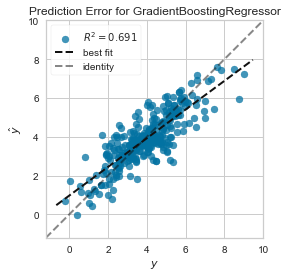

In [73]:
visualizer = prediction_error(final_model_energy_gdboost, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [74]:
forest_reg = RandomForestRegressor(random_state=10, n_jobs=-1)
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10),
        "bootstrap" : [True, False]
    }

rnd_search = RandomizedSearchCV(regressor, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906D8E28E0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906D8E2FA0>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [75]:
final_model_energy_forest = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_forest.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.62201
MSE:  0.66972
RMSE:  0.8183642428310232
RMPSE:  2.404
MAPE:  0.36159
R²:  0.69891


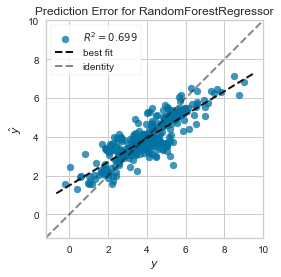

In [76]:
visualizer = prediction_error(final_model_energy_forest, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [77]:
feature_importances_forest = pd.DataFrame(final_model_energy_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_gradient = pd.DataFrame(final_model_energy_gdboost.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [78]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_forest.head()

,importance
LargestPropertyUseTypeGFA,0.18
PropertyGFABuilding(s),0.17
NaturalGas(kBtu)_binary,0.16
SecondLargestPropertyUseTypeGFA,0.07
NumberofFloors,0.07


In [79]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_gradient.head()

,importance
LargestPropertyUseTypeGFA,0.19
NaturalGas(kBtu)_binary,0.18
PropertyGFABuilding(s),0.17
NumberofFloors,0.10
SecondLargestPropertyUseTypeGFA,0.08


# Prédiction des émissions de CO2 avec ENERGYSTARScore

In [80]:
df = pd.read_csv("projet3.csv", sep=',')

X = df.drop(['TotalGHGEmissions_log','TotalGHGEmissions','SiteEnergyUse(kBtu)_log','SiteEnergyUse(kBtu)'], axis=1)
y = df['SiteEnergyUse(kBtu)_log']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

encoder = ce.OneHotEncoder(cols=['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

cols = X_train.columns

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  0.99894
MSE:  1.63439
RMSE:  1.2784327431976918
RMPSE:  0.084
MAPE:  0.0666
R²:  -0.00342


In [81]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
gdboost = GradientBoostingRegressor(random_state=10)
rdmforest = RandomForestRegressor(random_state=10)

In [82]:
model = [dummy_reg, lin_reg, gdboost, rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "GradientBoosting", "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,GradientBoosting,Random Forest
MAE,1.00,0.53,0.35,0.38
MSE,1.63,0.52,0.26,0.30
RMSE,1.28,0.72,0.51,0.55
R²,-0.00,0.68,0.84,0.81


In [83]:
# instanciation du modèle avec paramètre de base 
linear_reg = LinearRegression(n_jobs=-1)

In [84]:
param_distribs = {}

rnd_search = RandomizedSearchCV(linear_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LinearRegression(n_jobs=-1),
                   param_distributions={}, random_state=10,
                   scoring='neg_mean_squared_error')

In [85]:
final_model_energy_linear = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_linear.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.52801
MSE:  0.52353
RMSE:  0.7235553283409728
RMPSE:  0.049
MAPE:  0.03556
R²:  0.67858


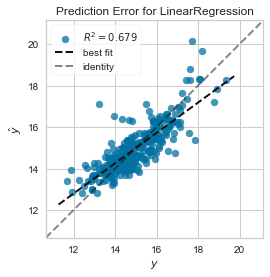

In [86]:
visualizer = prediction_error(final_model_energy_linear, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [87]:
gdboost = GradientBoostingRegressor()
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10)
    }
rnd_search = RandomizedSearchCV(gdboost, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906C7BC9A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906D7C4A90>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [88]:
final_model_energy_gdboost = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_gdboost.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.34547
MSE:  0.25852
RMSE:  0.5084506412918829
RMPSE:  0.035
MAPE:  0.02343
R²:  0.84128


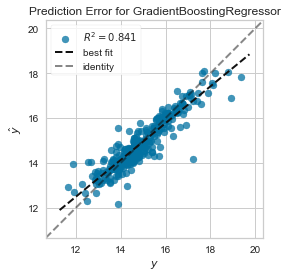

In [89]:
visualizer = prediction_error(final_model_energy_gdboost, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [90]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = regressor.predict(X_test)


In [91]:
# instanciation du modèle avec paramètre de base 
forest_reg = RandomForestRegressor(random_state=10, n_jobs=-1)

In [92]:
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10),
        "bootstrap" : [True, False]
    }

rnd_search = RandomizedSearchCV(regressor, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906C7BCB50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906F9D7D90>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [93]:
final_model_energy_forest = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_forest.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.39643
MSE:  0.32232
RMSE:  0.5677284138757362
RMPSE:  0.04
MAPE:  0.02707
R²:  0.80212


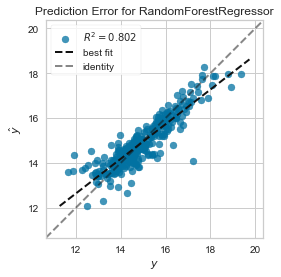

In [94]:
visualizer = prediction_error(final_model_energy_forest, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [95]:
feature_importances_forest = pd.DataFrame(final_model_energy_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_gradient = pd.DataFrame(final_model_energy_gdboost.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [96]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_forest.head()

,importance
PropertyGFABuilding(s),0.42
LargestPropertyUseTypeGFA,0.30
ENERGYSTARScore,0.12
PrimaryPropertyType_2,0.03
LargestPropertyUseType_2,0.02


In [97]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_gradient.head()

,importance
PropertyGFABuilding(s),0.21
LargestPropertyUseTypeGFA,0.19
ENERGYSTARScore,0.10
ThirdLargestPropertyUseTypeGFA,0.07
SecondLargestPropertyUseTypeGFA,0.06


# Prédiction des émissions de CO2 sans ENERGYSTARScore

In [98]:
df = pd.read_csv("projet3.csv", sep=',')

X = df.drop(['TotalGHGEmissions_log','TotalGHGEmissions','SiteEnergyUse(kBtu)_log','SiteEnergyUse(kBtu)','ENERGYSTARScore'], axis=1)
y = df['SiteEnergyUse(kBtu)_log']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

encoder = ce.OneHotEncoder(cols=['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

cols = X_train.columns

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  0.99894
MSE:  1.63439
RMSE:  1.2784327431976918
RMPSE:  0.084
MAPE:  0.0666
R²:  -0.00342


In [99]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
gdboost = GradientBoostingRegressor(random_state=10)
rdmforest = RandomForestRegressor(random_state=10)

In [100]:
model = [dummy_reg, lin_reg, gdboost, rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression", "GradientBoosting", "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,GradientBoosting,Random Forest
MAE,1.00,0.58,0.45,0.46
MSE,1.63,0.62,0.38,0.44
RMSE,1.28,0.79,0.62,0.66
R²,-0.00,0.62,0.76,0.73


In [101]:
# instanciation du modèle avec paramètre de base 
linear_reg = LinearRegression(n_jobs=-1)

In [102]:
param_distribs = {}

rnd_search = RandomizedSearchCV(linear_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LinearRegression(n_jobs=-1),
                   param_distributions={}, random_state=10,
                   scoring='neg_mean_squared_error')

In [103]:
final_model_energy_linear = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_linear.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.57884
MSE:  0.619
RMSE:  0.7867626708328386
RMPSE:  0.054
MAPE:  0.03921
R²:  0.61997


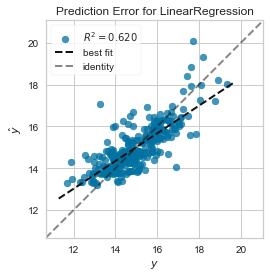

In [104]:
visualizer = prediction_error(final_model_energy_linear, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [105]:
gdboost = GradientBoostingRegressor()
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10)
    }
rnd_search = RandomizedSearchCV(gdboost, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906F9A9490>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906D8D4C40>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [106]:
final_model_energy_gdboost = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_gdboost.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.4565
MSE:  0.41535
RMSE:  0.6444766269827791
RMPSE:  0.044
MAPE:  0.03096
R²:  0.745


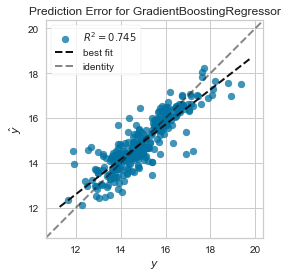

In [107]:
visualizer = prediction_error(final_model_energy_gdboost, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [108]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = regressor.predict(X_test)


In [109]:
# instanciation du modèle avec paramètre de base 
forest_reg = RandomForestRegressor(random_state=10, n_jobs=-1)

In [110]:
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10),
        "bootstrap" : [True, False]
    }

rnd_search = RandomizedSearchCV(regressor, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906A170670>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002906A170DF0>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [111]:
final_model_energy_forest = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_forest.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.44226
MSE:  0.38773
RMSE:  0.6226800071908627
RMPSE:  0.043
MAPE:  0.02999
R²:  0.76196


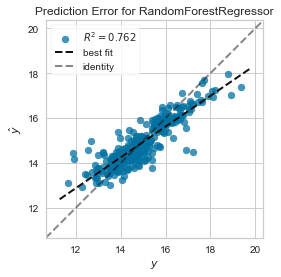

In [112]:
visualizer = prediction_error(final_model_energy_forest, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [113]:
feature_importances_forest = pd.DataFrame(final_model_energy_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_gradient = pd.DataFrame(final_model_energy_gdboost.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [114]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_forest.head()

,importance
PropertyGFABuilding(s),0.21
LargestPropertyUseTypeGFA,0.20
SecondLargestPropertyUseTypeGFA,0.10
NumberofFloors,0.09
PropertyGFAParking,0.04


In [115]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_gradient.head()

,importance
LargestPropertyUseTypeGFA,0.31
PropertyGFABuilding(s),0.16
SecondLargestPropertyUseTypeGFA,0.10
PrimaryPropertyType_6,0.05
PropertyGFAParking,0.04
